In [1]:
# notebook pour implementer l'analyse de fourier pour créer de nouvelles variables explicatives

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime

from numpy.fft import fft 
from numpy import pi, cos, sin 

In [2]:
#type pour chaque dataframe

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [3]:
#parametres de base pour le controle des jours à traiter

h = 28 
max_lags = 57 # nombre de jours max qu'on va regarder dans le passé
tr_last = 1913 # dernier jour à prédire dans la compet
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [4]:
def create_df(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("../../data/sell_prices.csv", dtype = PRICE_DTYPES)
    
    # one hot encoding pour toutes les variables catégorielles
    # ex : sunday = 0 etc...
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("../../data/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    
    # traiter les données depuis 5 ans en arrière serait trop long 
    # on décide donc de choisir un jour à partir duquel on va commencer à traiter les données
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    
    # on fait une liste des colonnes (elles ont des noms de type d_1300 on les selectionnes grace à ca)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    
    dtype = {numcol:"float32" for numcol in numcols}
    dtype.update({col: "category" for col in catcols if col != "id"})
    
    df = pd.read_csv("../../data/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    # one hot encoding sur la df de train
    for col in catcols:
        if col != "id":
            df[col] = df[col].cat.codes.astype("int16")
            df[col] -= df[col].min()
    
    # passage d'un format wide à un format long avec les jours et le nombre de sales pour la conversion
    df = pd.melt(df,
                  id_vars = catcols,
                  value_vars = [col for col in df.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    # merge de toutes les df
    df = df.merge(cal, on= "d", copy = False)
    df = df.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return df

In [5]:
FIRST_DAY = 1547 # si 0 souvent crash à cause de la mémoire

df = create_df(is_train=True, first_day= FIRST_DAY)
df.shape

(11156951, 22)

In [6]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
11156946,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,3.98
11156947,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
11156948,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
11156949,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.00
11156950,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1913,0.0,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.00


In [7]:
df_item = df[df['id'] == 'HOUSEHOLD_1_063_TX_2_validation']

In [8]:
df_item.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
15522,HOUSEHOLD_1_063_TX_2_validation,625,2,5,1,1,d_1547,0.0,2015-04-24,11512,...,4,2015,0,0,0,0,0.0,0.0,0.0,9.97
138759,HOUSEHOLD_1_063_TX_2_validation,625,2,5,1,1,d_1548,0.0,2015-04-25,11513,...,4,2015,0,0,0,0,0.0,0.0,0.0,9.97
138760,HOUSEHOLD_1_063_TX_2_validation,625,2,5,1,1,d_1549,0.0,2015-04-26,11513,...,4,2015,0,0,0,0,0.0,0.0,0.0,9.97
138761,HOUSEHOLD_1_063_TX_2_validation,625,2,5,1,1,d_1550,0.0,2015-04-27,11513,...,4,2015,0,0,0,0,0.0,0.0,0.0,9.97
138762,HOUSEHOLD_1_063_TX_2_validation,625,2,5,1,1,d_1551,0.0,2015-04-28,11513,...,4,2015,0,0,0,0,0.0,0.0,0.0,9.97


/Users/jerem/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


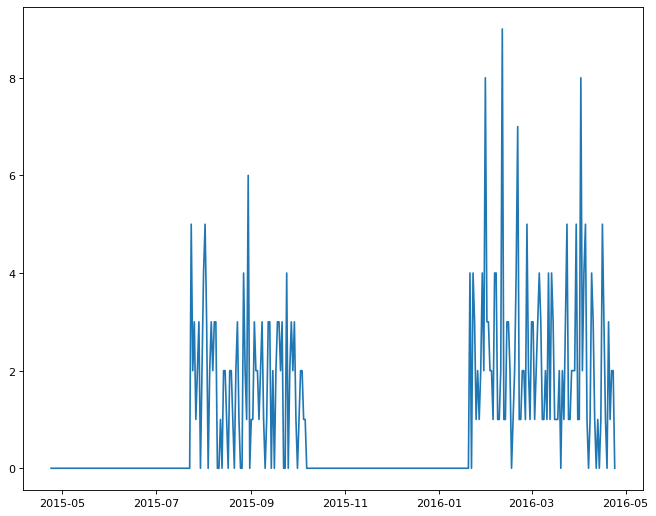

In [9]:
df_item_1000 = df_item[:1000]
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot('date','sales', data = df_item[:1000])



In [10]:
df_sy = pd.read_csv("../../data/sales_train_validation.csv")

In [11]:
df_sy.drop(['item_id','dept_id','cat_id','store_id','state_id'], axis= 1, inplace= True)

In [12]:
df_sy

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,2,2,0,3,1,4,1,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,5,0,1,1,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,0,6,0,2,2,4,1,8,5,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [13]:
df_select =df_sy[df_sy['id'] == 'HOUSEHOLD_1_063_TX_2_validation'] 

df_select = pd.melt(df_select,id_vars = 'id',
                  value_vars = [col for col in df_select.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

In [14]:
df_select

,id,d,sales
0,HOUSEHOLD_1_063_TX_2_validation,d_1,0
1,HOUSEHOLD_1_063_TX_2_validation,d_2,0
2,HOUSEHOLD_1_063_TX_2_validation,d_3,0
3,HOUSEHOLD_1_063_TX_2_validation,d_4,0
4,HOUSEHOLD_1_063_TX_2_validation,d_5,0
...,...,...,...
1908,HOUSEHOLD_1_063_TX_2_validation,d_1909,3
1909,HOUSEHOLD_1_063_TX_2_validation,d_1910,1
1910,HOUSEHOLD_1_063_TX_2_validation,d_1911,2
1911,HOUSEHOLD_1_063_TX_2_validation,d_1912,2


In [15]:
df_sy = pd.read_csv("../../data/sales_train_validation.csv")

df4=df_sy.groupby(['cat_id']).sum()
df4=df4.reset_index()
df4=df4.rename(columns={'cat_id': 'id'})
df4["id"] = [f"{lev+'_X'}" for lev in df4['id'].values]
df4

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_X,23178,22758,17174,18878,14603,22093,20490,27751,24862,...,28682,32007,34497,26151,24948,23632,23317,26704,31927,32654
1,HOBBIES_X,3764,3357,2682,2669,1814,3220,2944,3986,2899,...,3786,4634,4820,3323,3787,3472,3353,4085,4787,4683
2,HOUSEHOLD_X,5689,5634,3927,3865,2729,3898,4576,6195,4975,...,9321,11721,12323,8585,8835,8239,8363,9728,12248,12458


In [53]:
df4 = df4.drop([1,2])

In [55]:
df4 = pd.melt(df4,id_vars = 'id',
                  value_vars = [col for col in df4.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

df4

,id,d,sales
0,FOODS_X,d_1,23178
1,FOODS_X,d_2,22758
2,FOODS_X,d_3,17174
3,FOODS_X,d_4,18878
4,FOODS_X,d_5,14603
...,...,...,...
1908,FOODS_X,d_1909,23632
1909,FOODS_X,d_1910,23317
1910,FOODS_X,d_1911,26704
1911,FOODS_X,d_1912,31927


In [15]:
df_select.set_index('id',inplace=True)


In [16]:
df_select_1547 = df_select.iloc[1547:]
df_select_1547

,d,sales
id,,
HOUSEHOLD_1_063_TX_2_validation,d_1548,0
HOUSEHOLD_1_063_TX_2_validation,d_1549,0
HOUSEHOLD_1_063_TX_2_validation,d_1550,0
HOUSEHOLD_1_063_TX_2_validation,d_1551,0
HOUSEHOLD_1_063_TX_2_validation,d_1552,0
...,...,...
HOUSEHOLD_1_063_TX_2_validation,d_1909,3
HOUSEHOLD_1_063_TX_2_validation,d_1910,1
HOUSEHOLD_1_063_TX_2_validation,d_1911,2


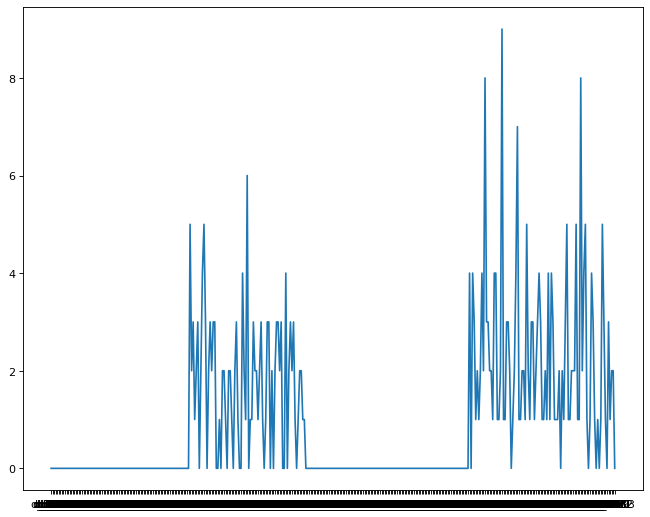

In [17]:
# affichage de l'année

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot('d','sales', data = df_select_1547)


(0.0, 60.0, 0.0, 4.0)

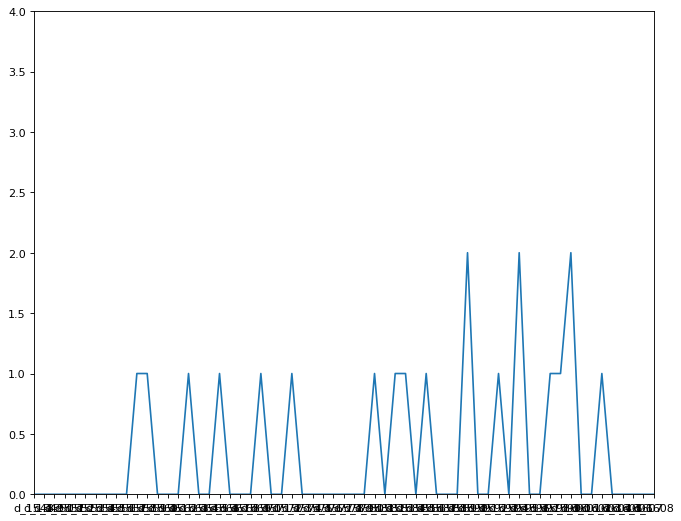

In [18]:
#zoom sur 2 mois
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot('d','sales', data = df_select_1547)
plt.axis([0, 60, 0, 4])

In [18]:
x = df_select_1547['sales']
M = len(x)
#M = 182
xf = fft(x,M)
f = np.arange(M)/M
f

array([0.        , 0.00273224, 0.00546448, 0.00819672, 0.01092896,
       0.0136612 , 0.01639344, 0.01912568, 0.02185792, 0.02459016,
       0.0273224 , 0.03005464, 0.03278689, 0.03551913, 0.03825137,
       0.04098361, 0.04371585, 0.04644809, 0.04918033, 0.05191257,
       0.05464481, 0.05737705, 0.06010929, 0.06284153, 0.06557377,
       0.06830601, 0.07103825, 0.07377049, 0.07650273, 0.07923497,
       0.08196721, 0.08469945, 0.08743169, 0.09016393, 0.09289617,
       0.09562842, 0.09836066, 0.1010929 , 0.10382514, 0.10655738,
       0.10928962, 0.11202186, 0.1147541 , 0.11748634, 0.12021858,
       0.12295082, 0.12568306, 0.1284153 , 0.13114754, 0.13387978,
       0.13661202, 0.13934426, 0.1420765 , 0.14480874, 0.14754098,
       0.15027322, 0.15300546, 0.1557377 , 0.15846995, 0.16120219,
       0.16393443, 0.16666667, 0.16939891, 0.17213115, 0.17486339,
       0.17759563, 0.18032787, 0.18306011, 0.18579235, 0.18852459,
       0.19125683, 0.19398907, 0.19672131, 0.19945355, 0.20218

Text(0.5, 0, 'Fréquence (réduite)')

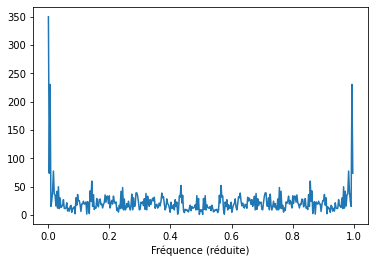

In [19]:
%matplotlib inline
plt.plot(f, np.abs(xf))
plt.xlabel("Fréquence (réduite)")

(0.0, 0.5, 0.0, 100.0)

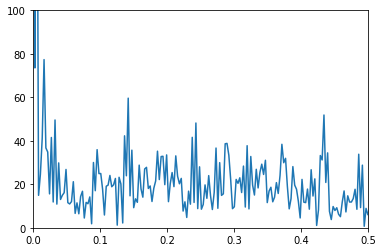

In [20]:
%matplotlib inline
plt.plot(f, np.abs(xf))
plt.axis([0, 0.5, 0, 100])

In [64]:
# trouver les max
from scipy.signal import find_peaks
# Cette fonction pour trouver les max, il faut utiliser les paramètres pour 
# trouver les "bons" max, sinon il y en a plus - Au pire, on peut lire à l'oeil sur le graphique
#print(np.abs(xf).sum()/xf
peaks = find_peaks(np.abs(xf), height=1, distance=10) # attention, la distance est en points pas en f
peaks[0] / M

array([0.03278689, 0.06010929, 0.10382514, 0.13934426, 0.16666667,
       0.20491803, 0.24043716, 0.28688525, 0.31693989, 0.3442623 ,
       0.38251366, 0.43169399, 0.46174863, 0.50819672, 0.53825137,
       0.56830601, 0.61748634, 0.6557377 , 0.68306011, 0.71311475,
       0.75956284, 0.79508197, 0.83333333, 0.86065574, 0.89617486,
       0.93989071, 0.96721311])

In [65]:
#ff1 = peaks[0][0] / M
#ff2 = peaks[0][1] / M
#ff3 = peaks[0][2]  / M
#ff4 = peaks[0][3]  / M
#ff5 = peaks[0][4]  / M
#ff6 = peaks[0][5]  / M
#ff7 = peaks[0][6]  / M
#ff8 = peaks[0][7]  / M

#ff1 = peaks[0][0] / M
#ff2 = peaks[0][1] / M
#ff3 = peaks[0][2]  / M
#ff4 = peaks[0][3]  / M

ff1 = peaks[0][0] / M
ff2 = peaks[0][1] / M
ff3 = peaks[0][2]  / M
ff4 = peaks[0][3]  / M
ff5 = peaks[0][4]  / M
ff6 = peaks[0][5]  / M
ff7 = peaks[0][6]  / M
ff8 = peaks[0][7] / M
ff9 = peaks[0][8] / M
ff10 = peaks[0][9]  / M
ff11 = peaks[0][10]  / M
ff12 = peaks[0][11]  / M
ff13 = peaks[0][12]  / M
ff14 = peaks[0][13]  / M

In [51]:
ff2

0.13934426229508196

In [52]:
from sklearn.linear_model import LinearRegression
import pandas as pd 

In [53]:
reg = LinearRegression()

In [66]:
t = np.arange(1547,1913)
x1c = cos(2*pi*ff1*t )
x1s = sin(2*pi*ff1*t )

x2c = cos(2*pi*ff2*t )
x2s = sin(2*pi*ff2*t )

x3c = cos(2*pi*ff3*t )
x3s = sin(2*pi*ff3*t )

x4c = cos(2*pi*ff4*t )
x4s = sin(2*pi*ff4*t )

x5c = cos(2*pi*ff5*t )
x5s = sin(2*pi*ff5*t )

x6c = cos(2*pi*ff6*t )
x6s = sin(2*pi*ff6*t )

x7c = cos(2*pi*ff7*t )
x7s = sin(2*pi*ff7*t )

x8c = cos(2*pi*ff8*t )
x8s = sin(2*pi*ff8*t )

x9c = cos(2*pi*ff9*t )
x9s = sin(2*pi*ff9*t )

x10c = cos(2*pi*ff10*t )
x10s = sin(2*pi*ff10*t )

x11c = cos(2*pi*ff11*t )
x11s = sin(2*pi*ff11*t )

x12c = cos(2*pi*ff12*t )
x12s = sin(2*pi*ff12*t )

x13c = cos(2*pi*ff13*t )
x13s = sin(2*pi*ff13*t )

x14c = cos(2*pi*ff14*t )
x14s = sin(2*pi*ff14*t )





X = pd.DataFrame(data = {"t":t, "x1c":x1c, "x1s":x1s, "x2c":x2c, "x2s":x2s, "x3c":x3c, "x3s":x3s, "x4c":x4c, "x4s": x4s,
                        "x5c":x5c,"x5s":x5s, "x6c":x6c,"x6s":x6s, "x7c":x7c,"x7s":x7s,
                        "x8c":x8c, "x8s":x8s, "x9c":x9c, "x9s":x9s, "x10c":x10c, "x10s":x10s, "x11c":x11c, "x11s": x11s,
                        "x12c":x12c, "x12s":x12s, "x13c":x13c, "x13s":x13s, "x14c":x14c, "x14s":x14s,})
X

,t,x1c,x1s,x2c,x2s,x3c,x3s,x4c,x4s,x5c,...,x10c,x10s,x11c,x11s,x12c,x12s,x13c,x13s,x14c,x14s
0,1547,-0.179281,-0.983798,0.997643,-0.068615,-0.739689,-0.672949,-0.916317,-0.400454,0.5,...,-0.894487,-0.447094,-0.008583,-0.999963,0.485060,-0.874481,-0.454755,0.890617,0.423914,0.905702
1,1548,0.025748,-0.999668,0.952635,0.304115,-0.179281,-0.983798,-0.279486,-0.960150,1.0,...,0.870285,-0.492548,0.679273,0.733885,-0.077175,0.997018,0.229688,-0.973264,-0.376728,-0.926324
2,1549,0.229688,-0.973264,0.773351,0.633978,0.454755,-0.890617,0.558244,-0.829677,0.5,...,-0.077175,0.997018,-0.996318,-0.085731,-0.344707,-0.938710,0.008583,0.999963,0.328542,0.944489
3,1550,0.423914,-0.905702,0.485060,0.874481,0.902030,-0.431673,0.994700,-0.102821,-0.5,...,-0.784120,-0.620609,0.794658,-0.607058,0.704066,0.710135,-0.246361,-0.969178,-0.279486,-0.960150
4,1551,0.600214,-0.799839,0.128398,0.991723,0.978856,0.204552,0.716152,0.697944,-1.0,...,0.952635,-0.304115,-0.179281,0.983798,-0.935717,-0.352752,0.469977,0.882679,0.229688,0.973264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,1908,-0.935717,-0.352752,-0.376728,-0.926324,0.815028,0.579421,0.679273,-0.733885,1.0,...,0.600214,-0.799839,0.514793,-0.857315,-0.469977,-0.882679,0.994700,0.102821,-0.640593,-0.767880
362,1909,-0.843776,-0.536696,-0.008583,-0.999963,0.295927,0.955211,0.998674,0.051479,0.5,...,0.328542,0.944489,0.196143,0.980575,0.794658,0.607058,-0.990584,0.136906,0.600214,0.799839
363,1910,-0.716152,-0.697944,0.360771,-0.932655,-0.344707,0.938710,0.600214,0.799839,-0.5,...,-0.967028,-0.254671,-0.804962,-0.593327,-0.975200,-0.221325,0.929523,-0.368763,-0.558244,-0.829677
364,1911,-0.558244,-0.829677,0.679273,-0.733885,-0.843776,0.536696,-0.229688,0.973264,-1.0,...,0.751132,-0.660152,0.994700,-0.102821,0.978856,-0.204552,-0.815028,0.579421,0.514793,0.857315


In [67]:
reg.fit(X,x)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
reg.coef_

array([ 9.78041768e-05,  9.71400350e-02,  1.09275631e-01, -2.11128844e-03,
        1.63273476e-01,  1.03970788e-01,  1.13387778e-01,  7.27179351e-02,
        1.66955198e-01,  6.03048980e-02,  1.41971378e-01,  6.78101648e-02,
        6.99898718e-02, -3.84375214e-02,  1.16895828e-01,  6.48634328e-03,
        8.44872184e-02, -7.83688269e-02,  1.93706356e-01,  9.67145636e-02,
        8.22011175e-02,  5.98290194e-02, -2.05452089e-01, -3.23817843e-02,
        1.61668318e-01, -5.75722980e-03, -1.44169671e-01, -1.50156293e-01,
       -6.76282406e-03])

In [69]:
xx = reg.predict(X)

In [70]:
x

id
FOODS_3_823_WI_3_validation    0
FOODS_3_823_WI_3_validation    0
FOODS_3_823_WI_3_validation    0
FOODS_3_823_WI_3_validation    0
FOODS_3_823_WI_3_validation    0
                              ..
FOODS_3_823_WI_3_validation    0
FOODS_3_823_WI_3_validation    1
FOODS_3_823_WI_3_validation    0
FOODS_3_823_WI_3_validation    0
FOODS_3_823_WI_3_validation    1
Name: sales, Length: 366, dtype: int64

In [73]:
df_xx = pd.DataFrame(xx)
df_xx = df_xx.set_index(x.index)
df_xx

,0
id,
FOODS_3_823_WI_3_validation,-0.091667
FOODS_3_823_WI_3_validation,0.707571
FOODS_3_823_WI_3_validation,0.235388
FOODS_3_823_WI_3_validation,1.099210
FOODS_3_823_WI_3_validation,0.431431
...,...
FOODS_3_823_WI_3_validation,0.427214
FOODS_3_823_WI_3_validation,0.491025
FOODS_3_823_WI_3_validation,1.015444


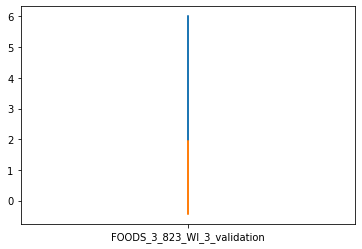

In [74]:
%matplotlib inline
plt.plot(x)
plt.plot(df_xx ) # + 0.2pour voir les 2 courbes
#plt.axis([0, 400, 15000, 40000])

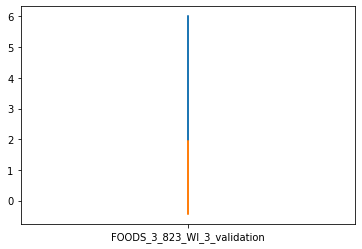

In [76]:
%matplotlib inline
plt.plot(x)
plt.plot(df_xx ) # + 0.2pour voir les 2 courbes
#plt.axis([0,1 , 0, 4])

In [ ]:
reelle 3
fourier 1
residus 2

-> 2 fourier 1 = 3

fourier_foods_001_CA_1  vente residus
1                       0        1
2                       1        1
3
0
0

???                   ???       
???                   ???